# **GPT**

# 1. Install required libraries

In [ ]:
!pip install transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load the dataset

In [ ]:
# Upload the dataset
from google.colab import files
uploaded = files.upload()

Saving HateSpeechDetection_test_Clean.csv to HateSpeechDetection_test_Clean.csv
Saving HateSpeechDetection_train_Clean.csv to HateSpeechDetection_train_Clean.csv


In [ ]:
train_df = pd.read_csv('HateSpeechDetection_test_Clean.csv')
test_df = pd.read_csv('HateSpeechDetection_train_Clean.csv')

In [ ]:
# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 3. Preprocess the data using GPT-2 tokenizer

In [ ]:
# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Use eos_token as padding token

# Preprocessing function to tokenize text
def preprocess_function(examples):
    return tokenizer(examples['prompt'], padding="max_length", truncation=True, max_length=128)

# Apply preprocessing to train and test datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

# Rename the 'label' column to 'labels' for compatibility with the Trainer
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

# Convert to PyTorch tensors
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

# 4. Load GPT-2 model（GPT2ForSequenceClassification）

In [ ]:
# Load GPT-2 for sequence classification
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)

# Set the padding token id to be the same as the tokenizer
model.config.pad_token_id = tokenizer.pad_token_id

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

# 5. Fine-tuning: Freeze lower layers of the GPT-2 model to reduce computation

In [ ]:
# Freeze the first 6 layers of GPT-2 to reduce computation and speed up training
for param in model.transformer.h[:6].parameters():
    param.requires_grad = False

# 6. Define evaluation metrics function

In [ ]:
# Define custom metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=1)
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# 7. Set training arguments with earlystoppingcallback

In [ ]:
from transformers import EarlyStoppingCallback

# Set training arguments with Early Stopping and optimizations
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Ensure evaluation happens at each epoch
    logging_strategy="epoch",
    save_strategy="epoch",  # Ensure checkpoints are saved at each epoch
    learning_rate=2e-5,  # Adjust the learning rate
    per_device_train_batch_size=4,  # Lower batch size if needed
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,  # Accumulate gradients over 4 steps
    num_train_epochs=10,  # Set higher epochs but Early Stopping will stop earlier if no improvement
    weight_decay=0.01,
    warmup_steps=500,  # Use warmup for learning rate
    fp16=True,  # Enable mixed precision training to speed up the process
    load_best_model_at_end=True,  # Required for EarlyStoppingCallback
    metric_for_best_model="accuracy",  # Metric to use for early stopping
    save_total_limit=2,  # Limit the number of saved checkpoints
)

# Define Early Stopping Callback (Ensure it's imported)
early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.001)


# 8. Pre-training Evaluation for Comparison

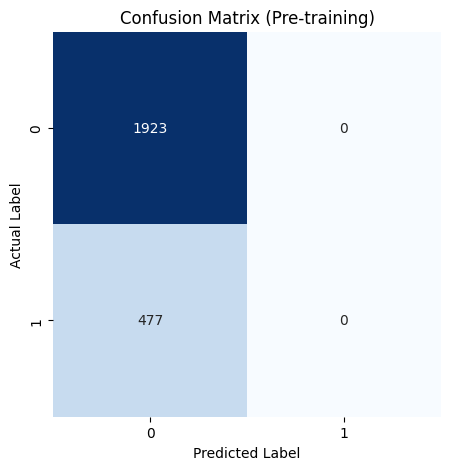

Before training predictions:
 {'test_loss': 1.8875648975372314, 'test_model_preparation_time': 0.0025, 'test_accuracy': 0.80125, 'test_precision': 1.0, 'test_recall': 0.0, 'test_f1': 0.0, 'test_runtime': 960.8468, 'test_samples_per_second': 2.498, 'test_steps_per_second': 0.312}


In [ ]:
# Initialize Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]  # Add early stopping callback here
)

# Pre-training evaluation (baseline)
predictions_before_training = trainer.predict(tokenized_test)

# Extract true and predicted labels
true_labels_pre = predictions_before_training.label_ids
predicted_labels_pre = predictions_before_training.predictions.argmax(-1)

# Plot confusion matrix for pre-training evaluation
cm_pre = confusion_matrix(true_labels_pre, predicted_labels_pre)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_pre, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Pre-training)')
plt.show()

# Print baseline results
print("Before training predictions:\n", predictions_before_training.metrics)

# 9. Model Training

In [ ]:
# Initialize Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]  # Add early stopping callback here
)

# Train the model with Early Stopping enabled
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,1.911500,1.822094,0.801250,1.000000,0.000000,0.000000
2,1.715700,1.594795,0.801250,1.000000,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,1.911500,1.822094,0.801250,1.000000,0.000000,0.000000
2,1.474400,1.170972,0.800000,0.000000,0.000000,1.000000


TrainOutput(global_step=112, training_loss=1.7006521565573556, metrics={'train_runtime': 5088.1809, 'train_samples_per_second': 1.179, 'train_steps_per_second': 0.073, 'total_flos': 117583537766400.0, 'train_loss': 1.7006521565573556, 'epoch': 2.986666666666667})

# 10. Model Evaluation

In [ ]:
# Evaluate the model after training
results = trainer.evaluate()

In [ ]:
# Plot confusion matrix for post-training evaluation
cm_post = confusion_matrix(true_labels_pre, predicted_labels_pre)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_post, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Post-training)')
plt.show()

# Print final evaluation results
print("Evaluation results:\n", results)

# 11. Model inference

In [ ]:
# Perform inference (prediction) on new text inputs
texts = ["I love programming.", "You are so stupid!"]

# Tokenize the input text
inference_encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')

# Ensure the model is in evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(**inference_encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

# Decode the predictions into labels
labels = ['Non-Toxic', 'Toxic']
predicted_labels = [labels[pred] for pred in predictions]

# Display the inference results
for i, text in enumerate(texts):
    print(f"Text: {text}")
    print(f"Predicted Label: {predicted_labels[i]}\n")


Text: I love programming.
Predicted Label: Non-Toxic

Text: You are so stupid!
Predicted Label: Non-Toxic

